In [372]:
import pandas as pd 
import numpy as np
import scipy 

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

from scipy.stats import spearmanr
from scipy.stats import chi2_contingency

sns.set_style("white")
sns.set_palette("muted")
%matplotlib inline 

In [194]:
df = pd.read_csv('./dataset_telecom_01.csv')

df.Factor_00 = df.Factor_00.astype('object')
df.rename(columns={'service_06':'Service_06'}, inplace=True)

# check id
# len(np.unique(df.uid)) == df.shape[0]
df.index = df.uid
df.drop('uid', axis=1, inplace=True)

# check nan 
df.isnull().apply(np.sum) # Charges 
df.Charges.mean(), df.Charges.median()
df.Charges.fillna(df.Charges.median(), inplace=True)

# target 
df['churn'] = 0
df.loc[df.is_churn == "Yes", 'churn'] = 1

# target 
factors = df.loc[:, df.dtypes == "object"].columns[:-1]

### Churn exploration

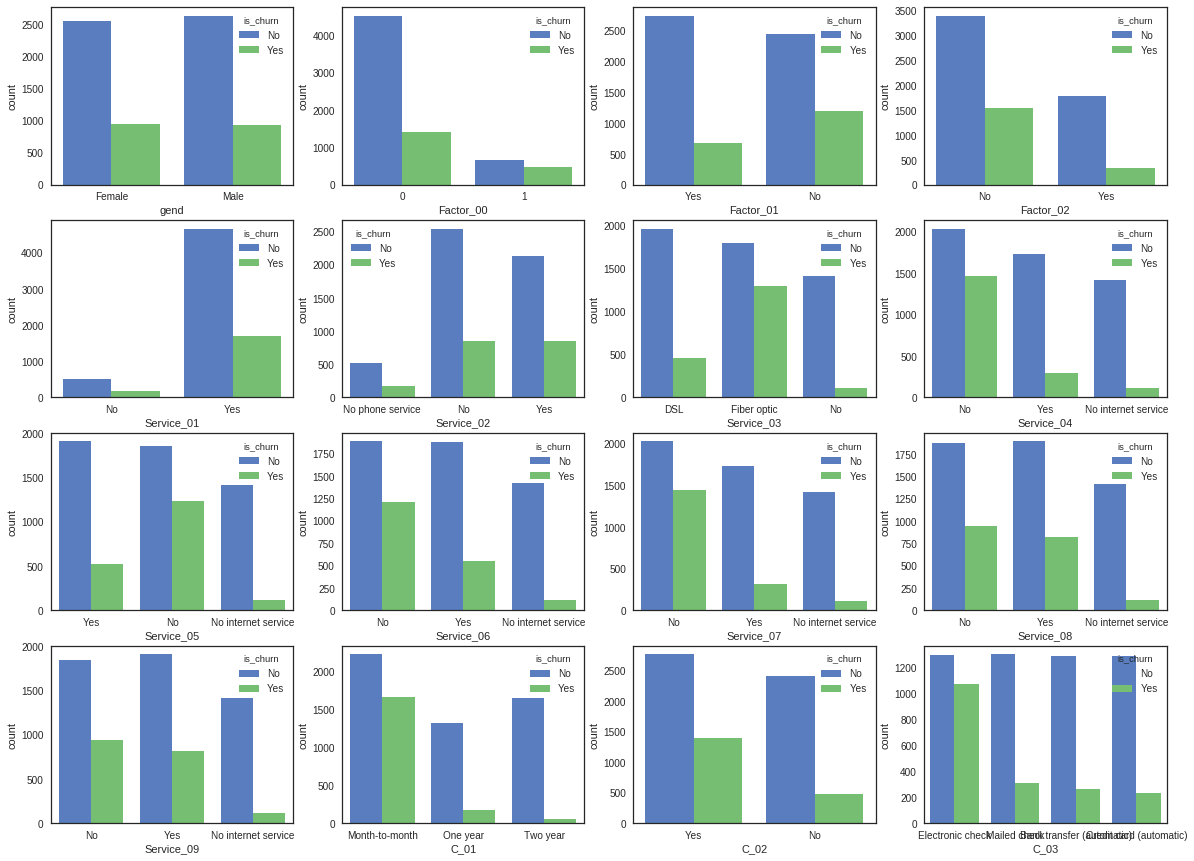

In [195]:
fig, axes = plt.subplots(4, 4, figsize=(20, 15))
for i in range(len(factors)):
    sns.countplot(x=factors[i], hue='is_churn', data=df, ax=axes[i // 4, i % 4])

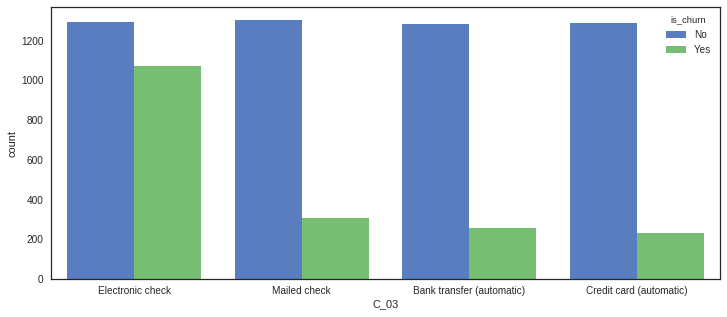

In [196]:
plt.figure(figsize=(12, 5))
sns.countplot(x=factors[-1], hue='is_churn', data=df);

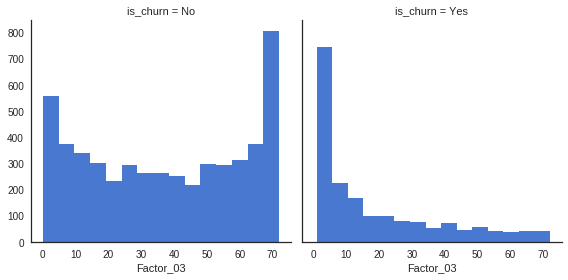

In [197]:
g = sns.FacetGrid(df, col="is_churn", margin_titles=True, size=4)
g.map(plt.hist, "Factor_03", bins=15);

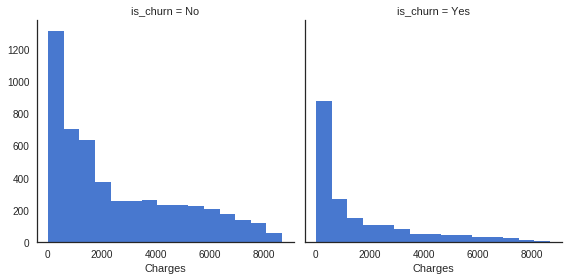

In [198]:
g = sns.FacetGrid(df, col="is_churn", margin_titles=True, size=4)
g.map(plt.hist, "Charges", bins=15);

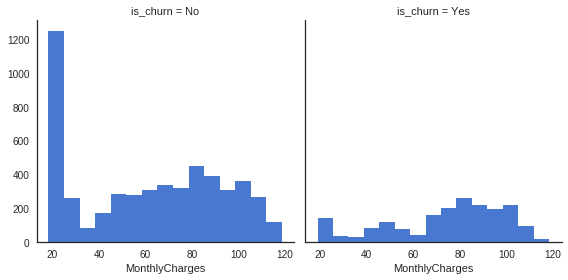

In [199]:
g = sns.FacetGrid(df, col="is_churn", margin_titles=True, size=4)
g.map(plt.hist, "MonthlyCharges", bins=15);

In [202]:
# group means 
# df_onehot = pd.get_dummies(data=df, columns=factors, prefix=factors, drop_first=True)

df_onehot_all = pd.get_dummies(data=df, columns=factors, prefix=factors, drop_first=False)
df_onehot_all.drop('is_churn', inplace=True, axis=1)

scaler = StandardScaler()
df_scaled = pd.DataFrame(data=scaler.fit_transform(df_onehot_all), columns=df_onehot_all.columns)

group_means = df_scaled.groupby('churn').agg(['mean'])
group_means.index = ['No', 'Yes']

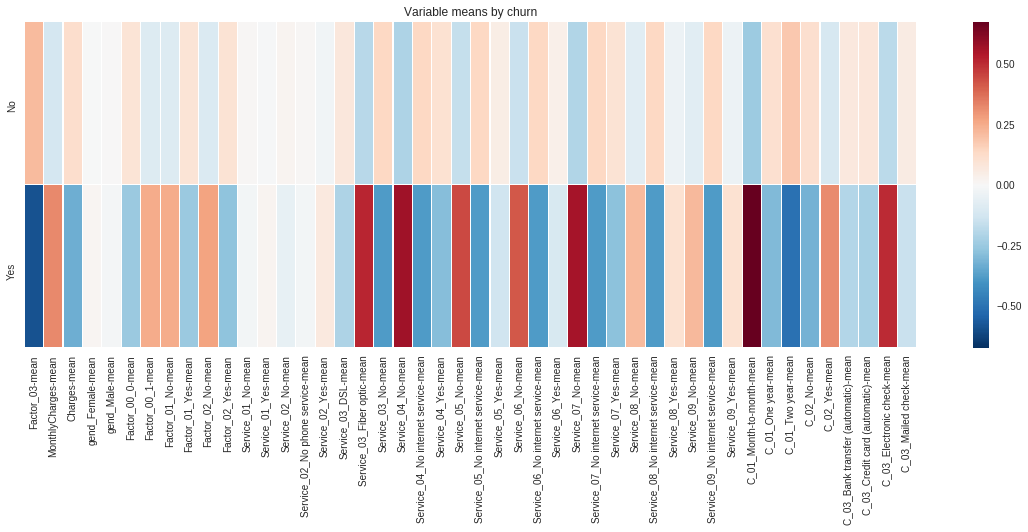

In [203]:
plt.figure(figsize=(20,6))
sns.heatmap(data=group_means, linewidths=0.1)
plt.title("Variable means by churn")
plt.xlabel("");

In [116]:
group_means.loc[:, group_means.loc["Yes", :] < -0.35]

,Factor_03,Service_03_No,Service_04_No internet service,Service_05_No internet service,Service_06_No internet service,Service_07_No internet service,Service_08_No internet service,Service_09_No internet service,C_01_Two year
,mean,mean,mean,mean,mean,mean,mean,mean,mean
No,0.211698,0.136968,0.136968,0.136968,0.136968,0.136968,0.136968,0.136968,0.181661
Yes,-0.586048,-0.379171,-0.379171,-0.379171,-0.379171,-0.379171,-0.379171,-0.379171,-0.502898


In [117]:
group_means.loc[:, group_means.loc["Yes", :] > 0.35]

,Service_03_Fiber optic,Service_04_No,Service_05_No,Service_06_No,Service_07_No,C_01_Month-to-month,C_03_Electronic check
,mean,mean,mean,mean,mean,mean,mean
No,-0.185127,-0.205933,-0.161077,-0.151747,-0.202714,-0.243476,-0.181460
Yes,0.512492,0.570089,0.445915,0.420086,0.561177,0.674022,0.502341


In [25]:
for serv in np.arange(3,10):
    serv_name = 'Service_0' + str(serv)
    print(df[serv_name].value_counts()[2], end=' ')

1526 1526 1526 1526 1526 1526 1526 

In [205]:
df['Internet'] = df.Service_03 != 'No'
df.Internet.value_counts()
df.Internet = df.Internet.astype('category')

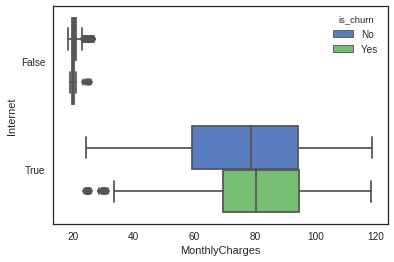

In [206]:
sns.boxplot(x="MonthlyCharges", y="Internet", hue="is_churn", data=df);

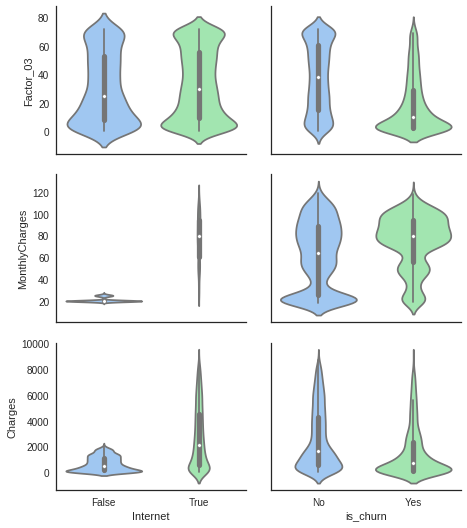

In [207]:
g = sns.PairGrid(df, 
                 x_vars=["Internet", "is_churn"],
                 y_vars=["Factor_03", "MonthlyCharges", "Charges"],
                 aspect=1.3, size=2.5)
g.map(sns.violinplot, palette="pastel");

### Feature selection

In [22]:
# corr total
def correl(df, corr):
    return (corr(df.Factor_03, df.Charges)[0], 
            corr(df.Factor_03, df.MonthlyCharges)[0], 
            corr(df.MonthlyCharges, df.Charges)[0])

print(correl(df, spearmanr))
print(correl(df.loc[df.Internet == True, :], spearmanr))
print(correl(df.loc[df.Internet == False, :], spearmanr))

(0.88699793260857263, 0.27641678933130215, 0.63747516670714599)
(0.95840390227239847, 0.38260817902124833, 0.59965441244163975)
(0.97261021866458175, 0.24136086041714058, 0.33585489914940697)


In [41]:
# chi2
def chi2_(df):
    chi2 = []
    for factor in factors:
        pval = chi2_contingency(pd.crosstab(df[factor], df.is_churn))[1]
        if pval > 0.01: chi2.append((factor, pval))
    return chi2

print(chi2_(df))
print(chi2_(df.loc[df.Internet == True, :]))
print(chi2_(df.loc[df.Internet == False, :]))

[('gend', 0.48657873605618596), ('Service_01', 0.33878253580669282)]
[('gend', 0.56048975633000131)]
[('gend', 0.97117080111281018), ('Factor_00', 0.72638577239957258), ('Service_01', 1.0), ('Service_03', 1.0), ('Service_04', 1.0), ('Service_05', 1.0), ('Service_06', 1.0), ('Service_07', 1.0), ('Service_08', 1.0), ('Service_09', 1.0), ('C_02', 0.068536878713470487)]


In [335]:
def check_metrics(X, y, estimator, T=0.5, cv=3):
    skf = StratifiedKFold(n_splits=cv)
    error = {'roc_auc': 0, "acc": 0, "recall": 0, "f1": 0}
    for train, test in skf.split(X, y):
        estimator.fit(X[train], y[train])
        y_pred_proba = estimator.predict_proba(X[test])
        error['roc_auc'] += roc_auc_score(y[test], y_pred_proba[:, 1])
        error['acc'] += accuracy_score(y[test], y_pred_proba[:, 1] > T)
        error['recall'] += recall_score(y[test], y_pred_proba[:, 1] > T)
        error['f1'] += f1_score(y[test], y_pred_proba[:, 1] > T)
    return list(zip(list(error.keys()), np.array(list(error.values())) / cv))

def plot_odds(coefs, names):
    odds = pd.Series(data=(np.exp(coefs)/(1+np.exp(coefs))).ravel(), index=names)
    plt.figure(figsize=(15,7))
    bar = sns.barplot(x=names, y=odds, color=sns.color_palette("pastel")[0])
    plt.setp(bar.get_xticklabels(), rotation=90)
    plt.axhline(y=0.5, color='g', linestyle='--');

### Logistic regression: all features

[('roc_auc', 0.8429891371140803), ('acc', 0.7704113555381511), ('recall', 0.73675762439807391), ('f1', 0.63007679702594954)]


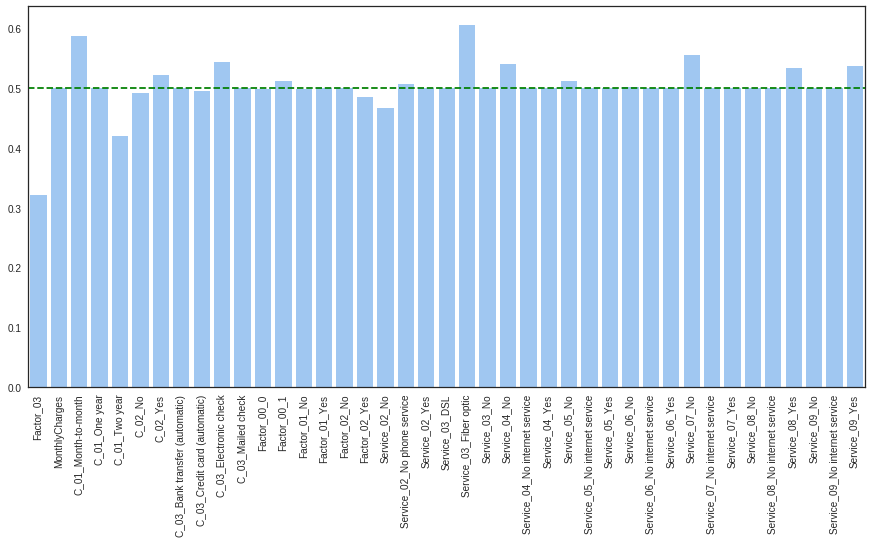

In [354]:
drop_features = ['gend', 'Service_01', 'Charges', 'is_churn', 'churn', 'Internet']
factors1 = sorted(list(set(factors).difference(drop_features)))

X = pd.get_dummies(data=df.drop(drop_features, axis=1),
                   columns=factors1, 
                   prefix=factors1, 
                   drop_first=False)
y = df.churn

scaler = StandardScaler()
X_scl = scaler.fit_transform(X)

lr = LogisticRegression(class_weight='balanced', warm_start=True)
params = {'penalty': ['l1', 'l2'], 
          'C': [0.01, 0.1]}

grid = GridSearchCV(cv=3, param_grid=params, estimator=lr, scoring='roc_auc', n_jobs=4)
grid.fit(X_scl, y)
lr_best = grid.best_estimator_

# print(lr_best)
print(check_metrics(X_scl, y, lr_best, 0.57))
plot_odds(lr_best.coef_, X.columns)

### LR for Internet users

LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=True)
[('roc_auc', 0.81871532787676538), ('acc', 0.75403471506123909), ('recall', 0.67198253648765593), ('f1', 0.63495726649707251)]


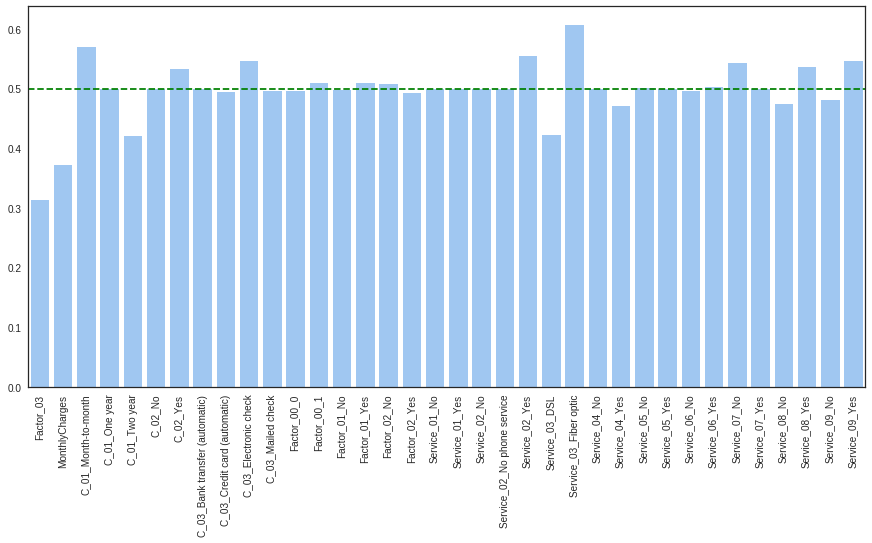

In [371]:
drop_features = ['gend', 'Charges', 'is_churn', 'churn', 'Internet']
factors1 = sorted(list(set(factors).difference(drop_features)))

X = pd.get_dummies(data=df.loc[df.Internet == True, :].drop(drop_features, axis=1),
                   columns=factors1, 
                   prefix=factors1, 
                   drop_first=False)

y = np.array(df.loc[df.Internet == True, :].churn)

scaler = StandardScaler()
X_scl = scaler.fit_transform(X)

lr = LogisticRegression(class_weight='balanced', warm_start=True)
#                         penalty='l1', C=0.1, )

params = {'penalty': ['l1', 'l2'], 
          'C': [0.01, 0.1, 1, 5]}
grid = GridSearchCV(cv=3, param_grid=params, estimator=lr, scoring='accuracy', n_jobs=4)
grid.fit(X_scl, y)
lr_best = grid.best_estimator_

print(lr_best)
print(check_metrics(X_scl, y, lr_best, 0.6))

plot_odds(lr_best.coef_, X.columns)

### LR for Non Internet users

LogisticRegression(C=5, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=True)
[('roc_auc', 0.81621656856319946), ('acc', 0.80144666346962035), ('recall', 0.75272641062114742), ('f1', 0.35935053917928172)]


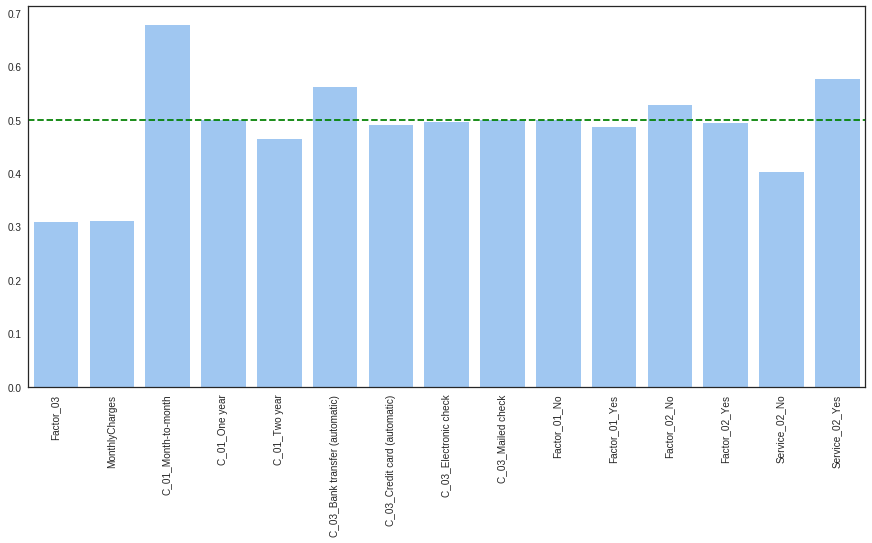

In [368]:
drop_features = ['gend', 'Charges', 'is_churn', 'churn', 'C_02', 'Factor_00', 
                'Service_01', 'Service_03', 'Service_04', 'Service_05', 'Service_06', 'Service_07', 
                'Service_08', 'Service_09', 'Internet']
factors1 = sorted(list(set(factors).difference(drop_features)))

X = pd.get_dummies(data=df.loc[df.Internet == False, :].drop(drop_features, axis=1),
                   columns=factors1, 
                   prefix=factors1, 
                   drop_first=False)

y = np.array(df.loc[df.Internet == False, :].churn)

scaler = StandardScaler()
X_scl = scaler.fit_transform(X)

lr = LogisticRegression(class_weight='balanced', warm_start=True)
#                         penalty='l1', C=0.1, )

params = {'penalty': ['l1', 'l2'], 
          'C': [0.01, 0.1, 1, 5]}
grid = GridSearchCV(cv=3, param_grid=params, estimator=lr, scoring='accuracy', n_jobs=4)
grid.fit(X_scl, y)
lr_best = grid.best_estimator_

print(lr_best)
print(check_metrics(X_scl, y, lr_best, 0.7))

plot_odds(lr_best.coef_, X.columns)

### Ensembles

In [383]:
from sklearn.ensemble import RandomForestClassifier

drop_features = ['is_churn', 'churn']
df1 = df.copy(deep=True)
df1.loc[:, factors] = df1.loc[:, factors].apply(lambda x: pd.factorize(x)[0])
names = df1.columns
X = np.array(df1.drop(drop_features, axis=1))
y = np.array(df.churn)

rf = RandomForestClassifier(n_estimators=300, 
                            class_weight='balanced', 
                            max_depth = 8,
                            min_samples_leaf = 2,
                            min_samples_split = 10
                           )

# param_grid = {
#     'max_depth': [4,6,8],
#     'min_samples_leaf': [2, 5,10],
#     'min_samples_split': [5, 10, 50]
# }

# grid = GridSearchCV(cv=3, param_grid=param_grid, estimator=rf, scoring='accuracy', n_jobs=4)
# grid.fit(X, y)
# rf = grid.best_estimator_
# print(rf)

check_metrics(X, y, rf, 0.55)

[('roc_auc', 0.84599374060299282),
 ('acc', 0.78404082246912521),
 ('recall', 0.71482075976458004),
 ('f1', 0.63711319899377672)]

#### Feature importances

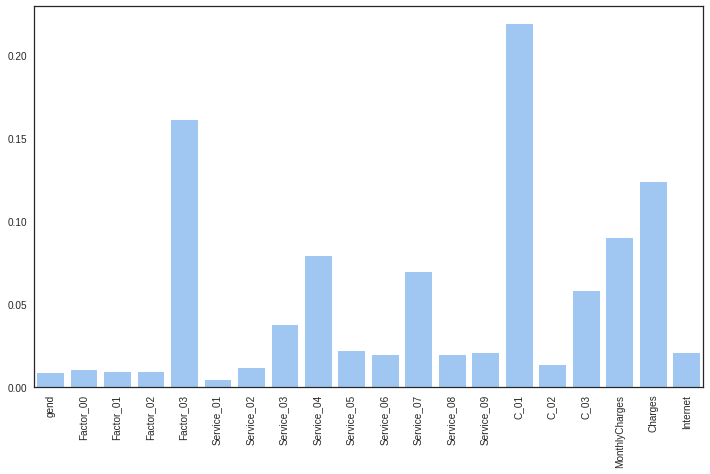

In [325]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
rf.fit(X_train, y_train)
plt.figure(figsize=(12,7))
bar = sns.barplot(x=names, y=rf.feature_importances_, color=sns.color_palette("pastel")[0])
plt.setp(bar.get_xticklabels(), rotation=90);